# Graphs for Data Visualization
Code authors: Caroline Parent & Hasti Honari

In [35]:
from pathlib import Path
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
from scipy.optimize import curve_fit 


## Create folder to save figures

In [36]:
def createFolder(folder_path):
    folder_path = Path(folder_path)
    folder_path.mkdir(parents=True, exist_ok=True)

# Create output folder specific to cell line
fig_folder = Path('output figures') / cell_line
createFolder(fig_folder)
print(f"Output folder created: {fig_folder}")

NameError: name 'cell_line' is not defined

## Load dataset

In [109]:
# Combine xlsx of experiments in one csv
#Remove rows with missing data
def clean_dataframe(df):
    # Remove completely empty columns
    df = df.dropna(axis=1, how="all")
    # Remove rows with any NaN left
    df = df.dropna(how="any")
    return df

# Build DataFrames from two Excel files
def build_dataframes(file_path_incubate, file_path_immediate):
    """Create incubate, immediate, and control DataFrames from two files"""
    all_sheets_incubate = pd.read_excel(file_path_incubate, sheet_name=None)
    all_sheets_immediate = pd.read_excel(file_path_immediate, sheet_name=None)

    # --- Create incubate ---
    dfs_incubate = [clean_dataframe(df) for name, df in all_sheets_incubate.items() if name != "Tube 1"]
    df_incubate = pd.concat(dfs_incubate, ignore_index=True)

    # --- Create immediate ---
    dfs_immediate = [clean_dataframe(df) for name, df in all_sheets_immediate.items() if name != "Tube 1"]
    df_immediate = pd.concat(dfs_immediate, ignore_index=True)

    # --- Create control ---
    dfs_control = []
    if "Tube 1" in all_sheets_incubate:
        dfs_control.append(clean_dataframe(all_sheets_incubate["Tube 1"]))
    if "Tube 1" in all_sheets_immediate:
        dfs_control.append(clean_dataframe(all_sheets_immediate["Tube 1"]))
    df_control = pd.concat(dfs_control, ignore_index=True)

    return df_incubate, df_immediate, df_control

In [110]:
# Define all experiment paths for different cell lines
# Files are organized as: Final_data_inc_day0.xlsx, Final_data_inc_day1.xlsx, Final_data_inc_day2.xlsx
#                        Final_data_imm_day0.xlsx, Final_data_imm_day1.xlsx, Final_data_imm_day2.xlsx
all_experiments_paths = {
    "MCF7": {
        "Exp1": {
            "base_path": r"E:\Experiments\PTT\Spheroids\01072025_mcf7",
        }
    },
    "MCF10": {
        "Exp1": {
            "base_path": r"E:\Experiments\PTT\Spheroids\01072025_mcf7",
        },
        "Exp2": {
            "base_path": r"E:\Experiments\PTT\Spheroids\02062025_mcf7\04062025 after laser",
        },
        "Exp3": {
            "base_path": r"E:\Experiments\PTT\Spheroids\05052025\07052025 after laser",
        },
    },
    "MDA": {
        "Exp1": {
            "base_path": r"E:\Experiments\PTT\Spheroids\01072025_mcf7",
        },
        "Exp2": {
            "base_path": r"E:\Experiments\PTT\Spheroids\02062025_mcf7\04062025 after laser",
        },
        "Exp3": {
            "base_path": r"E:\Experiments\PTT\Spheroids\05052025\07052025 after laser",
        },
    },
    "HS578T": {
        "Exp1": {
            "base_path": r"E:\Experiments\PTT\Spheroids\01072025_mcf7",
        },
        "Exp2": {
            "base_path": r"E:\Experiments\PTT\Spheroids\02062025_mcf7\04062025 after laser",
        },
        "Exp3": {
            "base_path": r"E:\Experiments\PTT\Spheroids\05052025\07052025 after laser",
        },
    },
    "PDX": {
        "Exp1": {
            "base_path": r"E:\Experiments\PTT\Spheroids\01072025_mcf7",
        },
        "Exp2": {
            "base_path": r"E:\Experiments\PTT\Spheroids\02062025_mcf7\04062025 after laser",
        },
        "Exp3": {
            "base_path": r"E:\Experiments\PTT\Spheroids\05052025\07052025 after laser",
        },
    },
    "A673": {
        "Exp1": {
            "base_path": r"E:\Experiments\PTT\Spheroids\01072025_mcf7",
        },
        "Exp2": {
            "base_path": r"E:\Experiments\PTT\Spheroids\02062025_mcf7\04062025 after laser",
        },
        "Exp3": {
            "base_path": r"E:\Experiments\PTT\Spheroids\05052025\07052025 after laser",
        },
    }
}

# SELECT CELL LINE HERE
cell_line = "MCF7"
experiments_paths = all_experiments_paths[cell_line]
print(f"Running analysis for cell line: {cell_line}")

Running analysis for cell line: MCF7


In [111]:
# Collect all incubate and immediate DataFrames, add Experiment ID column

dfs_incubate = []
dfs_immediate = []

for i, (exp_name, paths) in enumerate(experiments_paths.items(), start=1):
    df_incubate, df_immediate, df_control = build_dataframes(paths["incubate"], paths["immediate"])
    # Add Experiment ID column
    df_incubate["Experiment ID"] = i
    df_immediate["Experiment ID"] = i
    # Add Label column if Normalised alb exists
    if "Normalised alb" in df_incubate.columns:
        df_incubate["Label"] = np.where(df_incubate["Normalised alb"] > 50, "Alive", "Dead")
    if "Normalised alb" in df_immediate.columns:
        df_immediate["Label"] = np.where(df_immediate["Normalised alb"] > 50, "Alive", "Dead")
    dfs_incubate.append(df_incubate)
    dfs_immediate.append(df_immediate)

# Concatenate all experiments for each condition
df_incubate_all = pd.concat(dfs_incubate, ignore_index=True)
df_immediate_all = pd.concat(dfs_immediate, ignore_index=True)

save_folder = r"E:\Experiments\PTT\Spheroids\all data\mcf7"
# Save to CSV
df_incubate_all.to_csv(f"{save_folder}\\combined_incubate.csv", index=False)
df_immediate_all.to_csv(f"{save_folder}\\combined_immediate.csv",  index=False)

KeyError: 'incubate'

### Merge incubate and immediate data for each day (0, 1, 2)

In [112]:
def load_day_data(base_path, condition, day):
    """Load data for a specific day and condition (incubate or immediate)
    
    Expected file format: Final_data_inc_day0.xlsx or Final_data_imm_day0.xlsx
    """
    file_name = f"Final_data_{condition}_day{day}.xlsx"
    file_path = f"{base_path}\\{file_name}"
    
    try:
        all_sheets = pd.read_excel(file_path, sheet_name=None)
        
        dfs_day = []
        for name, df in all_sheets.items():
            if name != "Tube 1":
                df_clean = clean_dataframe(df)
                dfs_day.append(df_clean)
        
        if dfs_day:
            return pd.concat(dfs_day, ignore_index=True)
        else:
            return pd.DataFrame()
    except FileNotFoundError:
        print(f"File not found: {file_path}")
        return pd.DataFrame()
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return pd.DataFrame()

def merge_inc_imm_by_day_v2(base_path, day):
    """Merge incubate and immediate data for a specific day from separate files"""
    df_inc = load_day_data(base_path, "inc", day)
    df_imm = load_day_data(base_path, "imm", day)
    
    # Add condition column
    if not df_inc.empty:
        df_inc['Condition'] = 'Incubate'
    if not df_imm.empty:
        df_imm['Condition'] = 'Immediate'
    
    # Merge
    if not df_inc.empty and not df_imm.empty:
        df_merged = pd.concat([df_inc, df_imm], ignore_index=True)
        return df_merged
    elif not df_inc.empty:
        return df_inc
    elif not df_imm.empty:
        return df_imm
    else:
        return pd.DataFrame()

# Collect data for each day across all experiments
dfs_day0 = []
dfs_day1 = []
dfs_day2 = []

for i, (exp_name, paths) in enumerate(experiments_paths.items(), start=1):
    base_path = paths["base_path"]
    
    # Process each day
    for day, dfs_list in [(0, dfs_day0), (1, dfs_day1), (2, dfs_day2)]:
        df_day = merge_inc_imm_by_day_v2(base_path, day)
        if not df_day.empty:
            df_day["Experiment ID"] = i
            # Add Label column if Normalised alb exists
            if "Normalised alb" in df_day.columns:
                df_day["Label"] = np.where(df_day["Normalised alb"] > 50, "Alive", "Dead")
            dfs_list.append(df_day)
            print(f"Loaded {exp_name} day {day}: {df_day.shape[0]} rows")

# Concatenate all experiments for each day
df_day0_all = pd.concat(dfs_day0, ignore_index=True) if dfs_day0 else pd.DataFrame()
df_day1_all = pd.concat(dfs_day1, ignore_index=True) if dfs_day1 else pd.DataFrame()
df_day2_all = pd.concat(dfs_day2, ignore_index=True) if dfs_day2 else pd.DataFrame()

# Save to CSV
save_folder = rf"E:\Experiments\PTT\Spheroids\all data\{cell_line.lower()}"
Path(save_folder).mkdir(parents=True, exist_ok=True)

if not df_day0_all.empty:
    df_day0_all.to_csv(rf"{save_folder}\combined_day0.csv", index=False)
    print(f"\nDay 0 data saved: {df_day0_all.shape[0]} rows")
    
if not df_day1_all.empty:
    df_day1_all.to_csv(rf"{save_folder}\combined_day1.csv", index=False)
    print(f"Day 1 data saved: {df_day1_all.shape[0]} rows")
    
if not df_day2_all.empty:
    df_day2_all.to_csv(rf"{save_folder}\combined_day2.csv", index=False)
    print(f"Day 2 data saved: {df_day2_all.shape[0]} rows")

File not found: E:\Experiments\PTT\Spheroids\01072025_mcf7\Final_data_inc_day0.xlsx
File not found: E:\Experiments\PTT\Spheroids\01072025_mcf7\Final_data_imm_day0.xlsx
Loaded Exp1 day 1: 140 rows
Loaded Exp1 day 2: 123 rows
Day 1 data saved: 140 rows
Day 2 data saved: 123 rows
Day 1 data saved: 140 rows
Day 2 data saved: 123 rows


In [113]:
# --- Wide merge: append day1/day2 columns to day0 measurements ---
# This will create one wide DataFrame per experiment and condition where measurement
# columns are suffixed with _day0/_day1/_day2. If no reliable key column exists,
# rows are aligned by order using an internal '_row' index.

from functools import reduce

def combine_days_wide_for_experiment(base_path, experiment_id=None, save_per_experiment=False, save_folder=None):
    """Combine day0/1/2 files into wide format per condition for a single experiment.

    Expects files named:
      Final_data_inc_day0.xlsx, Final_data_inc_day1.xlsx, Final_data_inc_day2.xlsx
      Final_data_imm_day0.xlsx, Final_data_imm_day1.xlsx, Final_data_imm_day2.xlsx

    Returns dict: {'inc': df_inc_wide, 'imm': df_imm_wide}
    """
    results = {}
    conditions = [('inc', 'Incubate'), ('imm', 'Immediate')]

    # candidate key column names to keep (these will NOT be suffixed)
    key_candidates_names = ['tube', 'well', 'name', 'spheroid', 'id', 'sample', 'experiment id', 'experiment', 'plate', 'position']

    for cond_short, cond_label in conditions:
        day_dfs = []
        available_days = []
        for day in [0, 1, 2]:
            df = load_day_data(base_path, cond_short, day)  # uses previously defined function
            if df is None or df.empty:
                continue
            df = df.reset_index(drop=True).copy()
            df['_row'] = df.index

            # Determine key columns present in this df (case-insensitive match)
            key_cols = [c for c in df.columns if c.lower() in key_candidates_names]

            # Rename measurement columns to add suffix _day{day}
            rename_map = {}
            for col in df.columns:
                if col in key_cols or col == '_row':
                    continue
                # Avoid double-suffix if column already contains 'day' information
                if f"_day{day}" in col or f"day{day}" in col.lower():
                    new_name = col
                else:
                    new_name = f"{col}_day{day}"
                rename_map[col] = new_name

            df = df.rename(columns=rename_map)
            # Keep track of which key columns we saw across days
            day_dfs.append(df)
            available_days.append(day)

        if not day_dfs:
            # nothing for this condition
            results[cond_short] = pd.DataFrame()
            continue

        # Determine a common set of keys across all day dfs (intersection)
        all_key_sets = [set([c for c in df.columns if c.lower() in key_candidates_names]) for df in day_dfs]
        common_keys = list(set.intersection(*all_key_sets)) if all_key_sets else []

        # If no common keys, merge on internal '_row' index to align rows by order
        merge_on = ['_row'] + common_keys if common_keys else ['_row']

        # Merge all day dataframes outer-join on merge_on
        def _merge(left, right):
            return pd.merge(left, right, on=merge_on, how='outer', suffixes=(False, False))

        merged = reduce(_merge, day_dfs)

        # If we merged on '_row', drop it afterwards
        if '_row' in merged.columns:
            merged = merged.drop(columns=['_row'])

        # Add metadata columns
        merged['Condition'] = cond_label
        if experiment_id is not None:
            merged['Experiment ID'] = experiment_id

        # Optionally save per-experiment per-condition file
        if save_per_experiment and save_folder is not None:
            Path(save_folder).mkdir(parents=True, exist_ok=True)
            fname = Path(save_folder) / f"{cond_short}_experiment_{experiment_id}_wide.csv"
            merged.to_csv(fname, index=False)

        results[cond_short] = merged

    return results


# Run wide-merge across all experiments and aggregate
wide_inc_list = []
wide_imm_list = []

for i, (exp_name, paths) in enumerate(experiments_paths.items(), start=1):
    base_path = paths.get('base_path', paths.get('incubate', None) or paths.get('immediate', None))
    if base_path is None:
        print(f"No base path for {exp_name}, skipping")
        continue

    res = combine_days_wide_for_experiment(base_path, experiment_id=i, save_per_experiment=True, save_folder=rf"E:\Experiments\PTT\Spheroids\all data\{cell_line.lower()}")

    if not res.get('inc', pd.DataFrame()).empty:
        wide_inc_list.append(res['inc'])
    if not res.get('imm', pd.DataFrame()).empty:
        wide_imm_list.append(res['imm'])

# Concatenate across experiments (if any) and save aggregated files
save_folder = rf"E:\Experiments\PTT\Spheroids\all data\{cell_line.lower()}"
Path(save_folder).mkdir(parents=True, exist_ok=True)

combined_inc_wide = pd.concat(wide_inc_list, ignore_index=True) if wide_inc_list else pd.DataFrame()
combined_imm_wide = pd.concat(wide_imm_list, ignore_index=True) if wide_imm_list else pd.DataFrame()

if not combined_inc_wide.empty:
    combined_inc_wide.to_csv(Path(save_folder) / "combined_incubate_wide.csv", index=False)
    print(f"Saved combined incubate wide: {combined_inc_wide.shape[0]} rows -> {Path(save_folder) / 'combined_incubate_wide.csv'}")
if not combined_imm_wide.empty:
    combined_imm_wide.to_csv(Path(save_folder) / "combined_immediate_wide.csv", index=False)
    print(f"Saved combined immediate wide: {combined_imm_wide.shape[0]} rows -> {Path(save_folder) / 'combined_immediate_wide.csv'}")

# Also create a combined-all file with both conditions stacked (if both exist)
combined_all_wide = pd.concat([combined_inc_wide, combined_imm_wide], ignore_index=True) if (not combined_inc_wide.empty or not combined_imm_wide.empty) else pd.DataFrame()
if not combined_all_wide.empty:
    combined_all_wide.to_csv(Path(save_folder) / "combined_all_conditions_wide.csv", index=False)
    print(f"Saved combined all-conditions wide: {combined_all_wide.shape[0]} rows -> {Path(save_folder) / 'combined_all_conditions_wide.csv'}")

# Mark todo items as completed
combined_inc_wide


File not found: E:\Experiments\PTT\Spheroids\01072025_mcf7\Final_data_inc_day0.xlsx
File not found: E:\Experiments\PTT\Spheroids\01072025_mcf7\Final_data_imm_day0.xlsx
Saved combined incubate wide: 60 rows -> E:\Experiments\PTT\Spheroids\all data\mcf7\combined_incubate_wide.csv
Saved combined immediate wide: 80 rows -> E:\Experiments\PTT\Spheroids\all data\mcf7\combined_immediate_wide.csv
Saved combined all-conditions wide: 140 rows -> E:\Experiments\PTT\Spheroids\all data\mcf7\combined_all_conditions_wide.csv
File not found: E:\Experiments\PTT\Spheroids\01072025_mcf7\Final_data_imm_day0.xlsx
Saved combined incubate wide: 60 rows -> E:\Experiments\PTT\Spheroids\all data\mcf7\combined_incubate_wide.csv
Saved combined immediate wide: 80 rows -> E:\Experiments\PTT\Spheroids\all data\mcf7\combined_immediate_wide.csv
Saved combined all-conditions wide: 140 rows -> E:\Experiments\PTT\Spheroids\all data\mcf7\combined_all_conditions_wide.csv


,Name,Index_day1,Wells_day1,multiple_day1,Path 8bcrop_day1,Path segmented_day1,Area (um2)_day1,Centroid_day1,Perimeter (pix)_day1,Solidity_day1,...,Mean grey value_day2,Grey_in_day2,Grey_out_day2,Homogeneity_day2,Energy_day2,Correlation_day2,Normalised alb_day2,Max temp (°C)_day2,Condition,Experiment ID
0,1_0705_0,0,705,False,G:\Experiments\PTT\Spheroids\01072025_mcf7\030...,G:\Experiments\PTT\Spheroids\01072025_mcf7\030...,1755.0,"(74, 83)",162.710677,0.957969,...,19.807251,83.897104,103.704356,0.914882,0.906714,0.951040,136.239941,37.0,Incubate,1
1,2_1105_0,0,1105,False,G:\Experiments\PTT\Spheroids\01072025_mcf7\030...,G:\Experiments\PTT\Spheroids\01072025_mcf7\030...,2324.5,"(78, 66)",330.20815,0.69575,...,10.829578,91.327711,102.157289,0.923447,0.916781,0.944757,74.461661,37.0,Incubate,1
2,3_1305_0,0,1305,False,G:\Experiments\PTT\Spheroids\01072025_mcf7\030...,G:\Experiments\PTT\Spheroids\01072025_mcf7\030...,2088.5,"(79, 67)",238.752307,0.814865,...,21.737757,89.279843,111.017600,0.932909,0.928011,0.937262,73.567866,37.0,Incubate,1
3,4_1503_0,0,1503,False,G:\Experiments\PTT\Spheroids\01072025_mcf7\030...,G:\Experiments\PTT\Spheroids\01072025_mcf7\030...,1772.0,"(49, 73)",180.710677,0.92028,...,28.242010,85.929412,114.171422,0.931727,0.927116,0.917993,71.333378,37.0,Incubate,1
4,5_1301_0,0,1301,False,G:\Experiments\PTT\Spheroids\01072025_mcf7\030...,G:\Experiments\PTT\Spheroids\01072025_mcf7\030...,1619.0,"(79, 72)",175.053822,0.903712,...,28.267686,82.248136,110.515822,0.937468,0.933156,0.929496,79.313693,37.0,Incubate,1
5,6_1001_0,0,1001,False,G:\Experiments\PTT\Spheroids\01072025_mcf7\030...,G:\Experiments\PTT\Spheroids\01072025_mcf7\030...,1617.0,"(81, 69)",172.710677,0.91511,...,21.713760,82.423307,104.137067,0.933993,0.928637,0.935517,83.186806,44.0,Incubate,1
6,7_0701_0,0,701,False,G:\Experiments\PTT\Spheroids\01072025_mcf7\030...,G:\Experiments\PTT\Spheroids\01072025_mcf7\030...,1633.5,"(76, 76)",166.953317,0.941227,...,47.753981,52.439663,100.193644,0.930526,0.924298,0.902816,33.368358,59.0,Incubate,1
7,8_0501_0,0,501,False,G:\Experiments\PTT\Spheroids\01072025_mcf7\030...,G:\Experiments\PTT\Spheroids\01072025_mcf7\030...,1645.5,"(77, 72)",176.12489,0.911634,...,49.292028,55.892683,105.184711,0.948050,0.941613,0.889123,5.969276,63.0,Incubate,1
8,9_0202_0,0,202,False,G:\Experiments\PTT\Spheroids\01072025_mcf7\030...,G:\Experiments\PTT\Spheroids\01072025_mcf7\030...,1746.0,"(71, 77)",168.568542,0.952277,...,41.583420,63.757647,105.341067,0.945255,0.939733,0.921821,77.292013,46.0,Incubate,1
9,10_0204_0,0,204,False,G:\Experiments\PTT\Spheroids\01072025_mcf7\030...,G:\Experiments\PTT\Spheroids\01072025_mcf7\030...,1379.5,"(72, 70)",158.468036,0.918442,...,53.933322,55.086634,109.019956,0.949336,0.943849,0.897342,7.884551,55.0,Incubate,1


In [114]:
from pathlib import Path
import re

folder_dataset_processed = Path('data/processed_data')

# Base save folder for combined data
save_folder = Path(rf"E:\Experiments\PTT\Spheroids\all data\{cell_line.lower()}")

# Prefer wide combined files if present
inc_wide_path = save_folder / "combined_incubate_wide.csv"
imm_wide_path = save_folder / "combined_immediate_wide.csv"
all_wide_path = save_folder / "combined_all_conditions_wide.csv"

if inc_wide_path.exists():
    df_incubate_wide = pd.read_csv(inc_wide_path)
    print(f"Loaded wide incubate: {inc_wide_path} -> {df_incubate_wide.shape}")
else:
    df_incubate_wide = pd.DataFrame()
    print(f"No wide incubate file at {inc_wide_path}")

if imm_wide_path.exists():
    df_immediate_wide = pd.read_csv(imm_wide_path)
    print(f"Loaded wide immediate: {imm_wide_path} -> {df_immediate_wide.shape}")
else:
    df_immediate_wide = pd.DataFrame()
    print(f"No wide immediate file at {imm_wide_path}")

# If neither wide file exists but old combined CSVs exist, fall back to them
if df_incubate_wide.empty:
    old_inc = save_folder / "combined_incubate.csv"
    if old_inc.exists():
        df_incubate_wide = pd.read_csv(old_inc)
        print(f"Fallback loaded old incubate combined: {old_inc} -> {df_incubate_wide.shape}")

if df_immediate_wide.empty:
    old_imm = save_folder / "combined_immediate.csv"
    if old_imm.exists():
        df_immediate_wide = pd.read_csv(old_imm)
        print(f"Fallback loaded old immediate combined: {old_imm} -> {df_immediate_wide.shape}")

# Utility: convert wide (columns suffixed _day0/_day1/_day2) to long per-day rows
_day_pattern = re.compile(r"(.+)_day([012])$")

def wide_to_long(df_wide):
    if df_wide is None or df_wide.empty:
        return pd.DataFrame()

    # Identify day-specific columns and non-day columns
    day_cols = [c for c in df_wide.columns if _day_pattern.match(c)]
    non_day_cols = [c for c in df_wide.columns if c not in day_cols]

    # Group day columns by day
    day_to_cols = {0: [], 1: [], 2: []}
    for c in day_cols:
        m = _day_pattern.match(c)
        if m:
            base, day = m.group(1), int(m.group(2))
            day_to_cols[day].append((c, base))

    frames = []
    for day, pairs in day_to_cols.items():
        if not pairs:
            continue
        cols_for_day = non_day_cols + [p[0] for p in pairs]
        df_day = df_wide[cols_for_day].copy()
        # Rename day-specific columns back to base names
        rename_map = {orig: base for orig, base in pairs}
        df_day = df_day.rename(columns=rename_map)
        df_day['Day'] = day
        frames.append(df_day)

    if not frames:
        return pd.DataFrame()

    df_long = pd.concat(frames, ignore_index=True, sort=False)
    # If Experiment ID is present and duplicated per day, keep as is
    return df_long

# Convert wide -> long for both conditions
if not df_incubate_wide.empty:
    df_incubate = wide_to_long(df_incubate_wide)
    # Save long version for later re-use
    df_incubate.to_csv(save_folder / "combined_incubate_long.csv", index=False)
    print(f"Saved incubate long: {df_incubate.shape} -> {save_folder / 'combined_incubate_long.csv'}")
else:
    df_incubate = pd.DataFrame()

if not df_immediate_wide.empty:
    df_immediate = wide_to_long(df_immediate_wide)
    df_immediate.to_csv(save_folder / "combined_immediate_long.csv", index=False)
    print(f"Saved immediate long: {df_immediate.shape} -> {save_folder / 'combined_immediate_long.csv'}")
else:
    df_immediate = pd.DataFrame()

# For convenience, create combined all-conditions wide/long variables
if all_wide_path.exists():
    df_all_wide = pd.read_csv(all_wide_path)
else:
    df_all_wide = pd.concat([df_incubate_wide, df_immediate_wide], ignore_index=True) if (not df_incubate_wide.empty or not df_immediate_wide.empty) else pd.DataFrame()

if not df_all_wide.empty:
    df_all_long = wide_to_long(df_all_wide)
    df_all_long.to_csv(save_folder / "combined_all_conditions_long.csv", index=False)
else:
    df_all_long = pd.DataFrame()

print('Data preparation complete. Variables available: df_incubate_wide, df_immediate_wide, df_incubate, df_immediate, df_all_wide, df_all_long')

Loaded wide incubate: E:\Experiments\PTT\Spheroids\all data\mcf7\combined_incubate_wide.csv -> (60, 32)
Loaded wide immediate: E:\Experiments\PTT\Spheroids\all data\mcf7\combined_immediate_wide.csv -> (80, 33)
Saved incubate long: (120, 27) -> E:\Experiments\PTT\Spheroids\all data\mcf7\combined_incubate_long.csv
Saved immediate long: (160, 27) -> E:\Experiments\PTT\Spheroids\all data\mcf7\combined_immediate_long.csv
Data preparation complete. Variables available: df_incubate_wide, df_immediate_wide, df_incubate, df_immediate, df_all_wide, df_all_long
Saved incubate long: (120, 27) -> E:\Experiments\PTT\Spheroids\all data\mcf7\combined_incubate_long.csv
Saved immediate long: (160, 27) -> E:\Experiments\PTT\Spheroids\all data\mcf7\combined_immediate_long.csv
Data preparation complete. Variables available: df_incubate_wide, df_immediate_wide, df_incubate, df_immediate, df_all_wide, df_all_long


## Define  colors palette, sizes... for graphs

In [115]:
# Graph features
fontsize_title = 10
fontsize_label = 10
fontsize_tick = 9

# Color palette for classification
palette_class = {
            'high viab.': (51/255, 117/255, 56/255) ,  # Vert
            'intermediate' : (240/255, 228/255, 66/255), # Yellow
            'low viab.': (194/255, 106/255, 119/255)   # Magenta
             }

# Color palette cell type
palette_cells = {
    'incubate': (  7/255, 126/255, 151/255),     # Blue
    'immediate':  (255/255, 147/255,  38/255)      # Orange
}

palette_drug_incubate = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=False, n_colors=8)
palette_drug_immediate = sns.color_palette("Oranges", as_cmap=False, n_colors=8)

"""
colors_dict = {'incubate': ['#0F99B2', # bleu clair
                          '#055F72' # bleu foncé
                        ],
         'immediate': ['#FF9326', # orange clair
                 '#AC5600' # orange foncé
                ]}
"""
# Set graph theme
sns.set(font='Arial')
sns.set_theme(context='paper', style='ticks')


In [116]:
# Define kws_dict_incubate and kws_dict_immediate: dictionnaries with graph parameters perso

marker_size = 20
line_size = 1

kws_dict_incubate = {
   1:
        {
        'marker' : 's',
        'line' : 'dashdot',
        'marker_col' : (82/255, 24/255, 133/255),
        'line_col' : (82/255, 24/255, 133/255),
        'marker_size' : marker_size,
        'line_size' : line_size
        },
    2:
        {
        'marker' : 'o',
        'line' : '-',
        'marker_col' : (31/255, 79/255, 126/255),
        'line_col' : (1/255, 114/255, 114/255),
        'marker_size' : marker_size,
        'line_size' : line_size
        },
    3:
        {
        'marker' : '^',
        'line' : '--',
        'marker_col' : (131/255, 27/255, 91/255),
        'line_col' : (99/255, 20/255, 69/255),
        'marker_size' : marker_size,
        'line_size' : line_size
        },
    
}


kws_dict_immediate = {
   1:
        {
        'marker' : 's',
        'line' : 'dashdot',
        'marker_col' : (203/255, 60/255, 52/255),
        'line_col' : (166/255, 49/255, 43/255),
        'marker_size' : marker_size,
        'line_size' : line_size
        },
    2:
        {
        'marker' : 'o',
        'line' : '-',
        'marker_col' : (255/255, 128/255, 0/255),
        'line_col' : (192/255, 96/255, 0/255),
        'marker_size' : marker_size,
        'line_size' : line_size
        },
    3:
        {
        'marker' : '^',
        'line' : '--',
        'marker_col' : (129/255, 128/255, 71/255),
        'line_col' : (129/255, 128/255, 71/255),
        'marker_size' : marker_size,
        'line_size' : line_size
        },
    
}


## Dataset description

### Count NaN

In [117]:
# incubate
nan_rows = df_incubate.isna().any(axis=1)
print('For incubate: \nTotal rows with Nan:', nan_rows.sum())
print('Proportion of rows with Nan:', round(nan_rows.sum()/len(df_incubate)*100), '%')

# Count only for data at day 2

mask_experiment_2901 = df_incubate['Experiment ID'] == 1 # Create a mask for rows where 'Experiment ID' is 2901
cols_to_check = [col for col in df_incubate.columns if not col.endswith('day 1')] # Select columns that do not end with 'day 1'

nan_rows = df_incubate.loc[~mask_experiment_2901, cols_to_check].isna().any(axis=1) # Apply the mask: check for NaN values, but exclude 'day 1' columns for rows where 'Experiment ID' is 2901
print("\nDon't take into account data day 1 for experiment 2901 (missing data)")
print('Total rows with NaN:', nan_rows.sum())
print('Proportion of rows with NaN:', round(nan_rows.sum() / len(df_incubate) * 100, 2), '%')

# immediate
nan_rows = df_immediate.isna().any(axis=1)
print('\n\nFor immediate: \nTotal rows with Nan:', nan_rows.sum())
print('Proportion of rows with Nan:', round(nan_rows.sum()/len(df_immediate)*100), '%')

For incubate: 
Total rows with Nan: 120
Proportion of rows with Nan: 100 %

Don't take into account data day 1 for experiment 2901 (missing data)
Total rows with NaN: 0
Proportion of rows with NaN: 0.0 %


For immediate: 
Total rows with Nan: 160
Proportion of rows with Nan: 100 %


### Description classes

In [118]:
feat_incubate = [
   
   'Area',
   'Perimeter',
   'Circularity',
   'Aspect_Ratio',
   'Mean_Gray_Level',
   'Grey_in',
   'Grey_out',
   'Homogeneity',
   'Energy',
   'Correlation'
]

feat_immediate = [

   'Area',
   'Perimeter',
   'Circularity',
   'Aspect_Ratio',
   'Mean_Gray_Level',
   'Grey_in',
   'Grey_out',
   'Homogeneity',
   'Energy',
   'Correlation'
]

# ...existing code...
df_incubate_copy = df_incubate.copy()
df_immediate_copy = df_immediate.copy()

df_incubate_copy = df_incubate_copy.dropna(subset=feat_incubate).reset_index(drop=True)
df_immediate_copy = df_immediate_copy.dropna(subset=feat_immediate).reset_index(drop=True)

# Add '2 classes' and '3 classes' columns based on 'viability score'
df_incubate_copy['2 classes'] = np.where(df_incubate_copy['Normalised alb'] > 50, 'high viab.', 'low viab.')
df_immediate_copy['2 classes'] = np.where(df_immediate_copy['Normalised alb'] > 50, 'high viab.', 'low viab.')

df_incubate_copy['3 classes'] = pd.cut(df_incubate_copy['Normalised alb'], bins=[-np.inf, 33, 66, np.inf], labels=['low viab.', 'intermediate', 'high viab.'])
df_immediate_copy['3 classes'] = pd.cut(df_immediate_copy['Normalised alb'], bins=[-np.inf, 33, 66, np.inf], labels=['low viab.', 'intermediate', 'high viab.'])

print(df_incubate_copy)

KeyError: ['Area', 'Mean_Gray_Level']

ValueError: Could not interpret value `2 classes` for `hue`. An entry with this name does not appear in `data`.

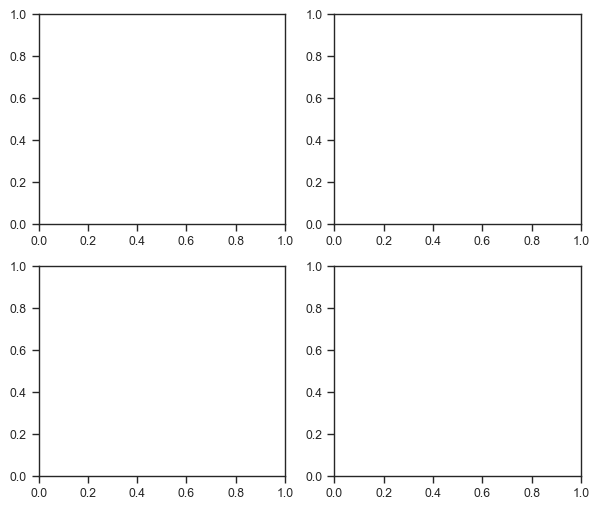

In [119]:
x = 'Experiment ID'
h2 = '2 classes'
h3 = '3 classes'

# Transform Experiment ID into string values
df_incubate_copy[x] = df_incubate_copy[x].astype('str')
df_immediate_copy[x] = df_immediate_copy[x].astype('str')

# Initialize figure
fig, axes = plt.subplots(2, 2, figsize=(7, 6))
axes = axes.flatten()


### Plot histograms
# incubate, 2 classes
sns.histplot(data=df_incubate_copy, x=x, hue=h2, multiple='stack', palette=palette_class, shrink=.8, ax=axes[0], legend=False)

# immediate, 2 classes
sns.histplot(data=df_immediate_copy, x=x, hue=h2, multiple='stack', palette=palette_class, shrink=.8, ax=axes[1])

# incubate, 2 classes
sns.histplot(data=df_incubate_copy, x=x, hue=h3, multiple='stack', palette=palette_class, shrink=.8, ax=axes[2], legend=False)

# immediate, 3 classes
sns.histplot(data=df_immediate_copy, x=x, hue=h3, multiple='stack', palette=palette_class, shrink=.8, ax=axes[3])


### Add numbers corresponding to each bar
def number(axes):
    for p in axes.patches:
    # Coordinates of each bar
        height = p.get_height()
        width = p.get_width()
        x_pos = p.get_x() + width / 2 
        y_pos = p.get_y() + height / 2
        offset = 0.05 
    
        # If bars greater than 0, displays the number of elements corresponding to the bar
        if height > 0:
            axes.text(x_pos, y_pos + offset, f'{int(height)}', ha='center', va='center')

for i in range(4):
    number(axes[i])

### Add titles
axes[0].set_title('incubate, 2 classes')
axes[1].set_title('immediate, 2 classes')
axes[2].set_title('incubate, 3 classes')
axes[3].set_title('immediate, 3 classes')

# Change labels legend
axes[1].legend(['low viab.', 'high viab.'])
axes[3].legend(['high viab.', 'intermediate', 'low viab.'])

sns.move_legend(axes[1], "upper right", bbox_to_anchor=(1.6, 1))
sns.move_legend(axes[3], "upper right", bbox_to_anchor=(1.6, 1))

plt.tight_layout()
plt.savefig(fig_folder / "S9_dataset_description.svg", format='svg', bbox_inches='tight', transparent=False)
plt.show()

In [73]:
df_incubate_copy.groupby('Experiment ID')['3 classes'].value_counts()

Experiment ID  3 classes   
1              high viab.      34
               low viab.       13
               intermediate     4
Name: count, dtype: int64

## Save .csv for each feature for GraphPrism plot

In [74]:
def featureToCsvPrism(df, x, y, replace0=(True, 0.001)):
    # x vector sorted and without repetition
    x_values = sorted(df[x].unique())

    # Determine the maximum number of replicates per x_value
    n_replicats = df[x].value_counts().max()

    # Create a new DataFrame with replicates as rows and x values as columns
    new_df = pd.DataFrame(index=list(range(1, n_replicats + 1)), columns=x_values)

    # Populate the new DataFrame with values from `y`
    for x_value in x_values:
        # Take the values of the columns y where column x is equal to x_value, reset index
        filtered_values = df.loc[df[x] == x_value, y].reset_index(drop=True)

        # Add theses values to a new dataframe, 1 column corresponds to the same x_value
        new_df[x_value] = filtered_values.reindex(range(len(new_df)), fill_value=None).values

        # Rename the column with `0` (optional)
        if replace0[0] == True and 0 in new_df.columns:
            new_df.rename(columns={0: replace0[1]}, inplace=True)

        new_df_t = new_df.transpose()

    return new_df_t



def savefeatureToCsvPrism(df, x, cols, folder_name):
    # Create output folder
    folder_csv_features = Path(fig_folder) / folder_name
    createFolder(folder_csv_features)

    # Get unique experiment IDs
    exps = df['Experiment ID'].unique()

    for y in cols:
        # Save data of each experiment independently
        for exp in exps:
            # Filter data for each experiment
            df_filtered = df[df['Experiment ID'] == exp]
            # Format data
            df_prism = featureToCsvPrism(df_filtered, x, y)
            # Save to CSV
            name = f"{y} exp {exp}.csv"
            path = folder_csv_features / name
            df_prism.to_csv(path)
        
        # Save combined data across all experiments
        df_prism = featureToCsvPrism(df, x, y)
        name = f"{y} all.csv"
        path = folder_csv_features / name
        df_prism.to_csv(path)


### Save .csv files for each feature

In [ ]:
### Save features .csv independently
x = 'Max temp (°C)'
cols = df_incubate.columns[4:-5]
print(cols)

# For incubate
df = df_incubate.copy()
folder_name = 'csv features incubate'
savefeatureToCsvPrism(df, x, cols, folder_name)

# For immediate
df = df_immediate.copy()
folder_name = 'csv features immediate'
savefeatureToCsvPrism(df, x, cols, folder_name)

print(".csv files have been saved !")

Index(['Wells', 'multiple', 'Path 8bcrop', 'Path segmented', 'Area (pix2)',
       'Centroid', 'Perimeter (pix)', 'Solidity', 'Equivalent Diameter (pix)',
       'Circularity', 'Aspect ratio', 'Mean grey value', 'Homogeneity',
       'Energy', 'Correlation', 'Day', 'File', 'Area', 'Perimeter',
       'Aspect_Ratio'],
      dtype='object')


KeyError: 'Max temp (°C)_day2'

### Save .csv files for viability score

In [76]:
### Save metabolic activity independently
x = 'Max temp (°C)'
cols = ['Normalised alb']

df = df_incubate.copy()
folder_name = 'csv viability score incubate'
savefeatureToCsvPrism(df, x, cols, folder_name)

df = df_immediate.copy()
folder_name = 'csv viability score immediate'
savefeatureToCsvPrism(df, x, cols, folder_name)

print(".csv files have been saved !")


.csv files have been saved !


## Description of data

### Plot feature evolution VS day

In [121]:
import re

def featureVSday(fig, ax, df, feature, legend_display=True, palette='rocket'):
    """Plot feature values at day0/1/2 for each row in `df` using a continuous
    colormap mapped to per-row 'Max temp' value. The function will locate
    temperature columns like 'Max temp (°C)', or day-specific columns
    'Max temp (°C)_day0/_day1/_day2' and pick the best available value
    for each row (prefer day2 > day1 > day0). Works with wide or long tables.
    """
    from matplotlib.colors import ListedColormap

    x = [1, 2]

    # column name patterns for temperature
    temp_base_pattern = re.compile(r"max\s*temp", flags=re.I)
    temp_day_pattern = re.compile(r"max\s*temp.*_day([0-2])", flags=re.I)

    # Helper to find candidate temp columns in df
    temp_cols = [c for c in df.columns if temp_base_pattern.search(c)]
    # build mapping day -> column name for day-specific temp columns
    temp_day_cols = {}
    if df.columns.size > 0:
        for c in df.columns:
            m = temp_day_pattern.search(c)
            if m:
                try:
                    day_idx = int(m.group(1))
                    temp_day_cols[day_idx] = c
                except Exception:
                    continue

    # Simpler reliable approach: collect explicit day columns if present
    temp_day0 = next((c for c in df.columns if re.search(r"max\s*temp.*_day0", c, flags=re.I)), None)
    temp_day1 = next((c for c in df.columns if re.search(r"max\s*temp.*_day1", c, flags=re.I)), None)
    temp_day2 = next((c for c in df.columns if re.search(r"max\s*temp.*_day2", c, flags=re.I)), None)
    temp_plain = next((c for c in df.columns if re.search(r"^max\s*temp.*$", c, flags=re.I) and not re.search(r"_day[0-2]", c, flags=re.I)), None)

    # Function to get a representative temperature value for a row
    def get_row_temp(row):
        # Prefer day2, then day1, then day0, then plain, then any temp_cols
        for col in (temp_day2, temp_day1, temp_day0, temp_plain):
            if col is not None and col in row.index:
                val = row.get(col)
                if pd.notna(val):
                    try:
                        return float(val)
                    except Exception:
                        return np.nan
        # fallback: check any column that contains 'max temp'
        for col in temp_cols:
            if col in row.index:
                val = row.get(col)
                if pd.notna(val):
                    try:
                        return float(val)
                    except Exception:
                        continue
        return np.nan

    # Build per-row temperature Series to set colormap limits
    temp_series = df.apply(get_row_temp, axis=1)
    temp_vals = temp_series.dropna().values

    cmap = None; norm = None; sm = None
    if temp_vals.size > 0:
        vmin, vmax = float(temp_vals.min()), float(temp_vals.max())
        if vmin == vmax:
            vmin -= 1.0; vmax += 1.0
        norm = plt.Normalize(vmin=vmin, vmax=vmax)
        # Build cmap from palette input
        try:
            if isinstance(palette, (list, tuple, np.ndarray)):
                cmap = ListedColormap(palette)
            elif isinstance(palette, str):
                try:
                    cmap = sns.color_palette(palette, as_cmap=True)
                except Exception:
                    cmap = plt.get_cmap(palette)
            else:
                try:
                    cmap = sns.color_palette(palette, as_cmap=True)
                except Exception:
                    cmap = plt.cm.viridis
        except Exception:
            cmap = plt.cm.viridis

        sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
        sm.set_array([])

    default_color = (0.5, 0.5, 0.5)

    # Helper: generate candidate column names for a feature and day
    def col_candidates(feature_name, day):
        base = re.sub(r"\s*\(.*?\)", "", feature_name).strip()
        candidates = [
            f"{feature_name}_day{day}",
            f"{base}_day{day}",
            f"{feature_name.replace(' ', '_')}_day{day}",
            f"{base.replace(' ', '_')}_day{day}",
        ]
        candidates += [c.lower() for c in candidates]
        seen = set(); out = []
        for c in candidates:
            if c not in seen:
                out.append(c); seen.add(c)
        return out

    # Iterate rows and plot
    for idx, row in df.iterrows():
        y_values = []
        for day in x:
            val = np.nan
            for cand in col_candidates(feature, day):
                if cand in df.columns:
                    val = row.get(cand, np.nan)
                    break
            y_values.append(val)

        if all([pd.isna(v) for v in y_values]):
            continue

        # get temperature for this row
        conc = get_row_temp(row)

        if pd.notna(conc) and cmap is not None and norm is not None:
            color = cmap(norm(conc))
        else:
            color = default_color

        ax.plot(x, y_values, marker='o', color=color, label=(conc if pd.notna(conc) else None))

    # Axis formatting
    ax.set_xlabel('drug exposure time (h)')
    ax.set_ylabel(feature)
    ax.set_xticks([0, 1, 2])
    ax.set_xticklabels(['0', '24', '48'])
    ax.grid(True)

    # Add colorbar
    if sm is not None:
        try:
            cbar = fig.colorbar(sm, ax=ax, orientation='vertical', pad=0.02)
            cbar.set_label('Max temp (°C)')
        except Exception:
            pass

    return


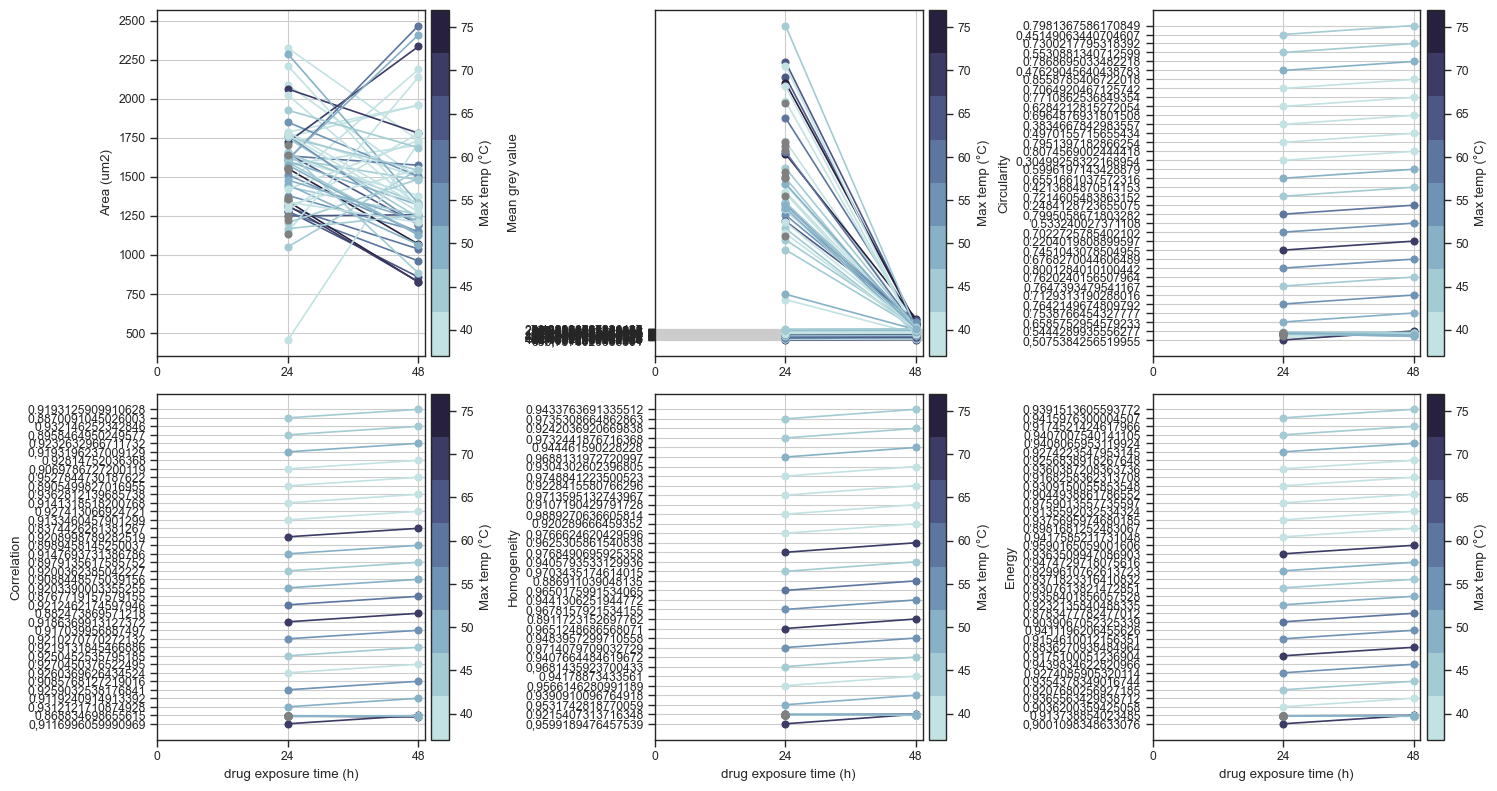

0    37.0
1    37.0
2    37.0
3    37.0
4    37.0
Name: Max temp (°C)_day2, dtype: float64
count    51.000000
mean     48.392157
std      10.971014
min      37.000000
25%      40.500000
50%      46.000000
75%      55.500000
max      77.000000
Name: Max temp (°C)_day2, dtype: float64


In [122]:
features = ['Area (um2)',
            'Mean grey value',
            'Circularity',
            'Correlation',
            'Homogeneity',
            'Energy',
           # 'Solidity',
           # 'Equivalent Diameter (um)',
            #'Perimeter (um)'
            ]

df = combined_inc_wide.copy()
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
axes = axes.flatten()

for i, feature in enumerate(features):
    featureVSday(fig, axes[i], df, feature, legend_display=True, palette=palette_drug_incubate)

# Hide x labels for the first line
for ax in axes[:3]:
    ax.set_xlabel('') 

plt.tight_layout()
plt.savefig(fig_folder / "S2 feature VS time incubate.svg", format='svg', bbox_inches='tight', transparent=False)
plt.show()
print(df['Max temp (°C)_day2'].head())
print(df['Max temp (°C)_day2'].describe())

KeyError: 'Area (um2)_day0'

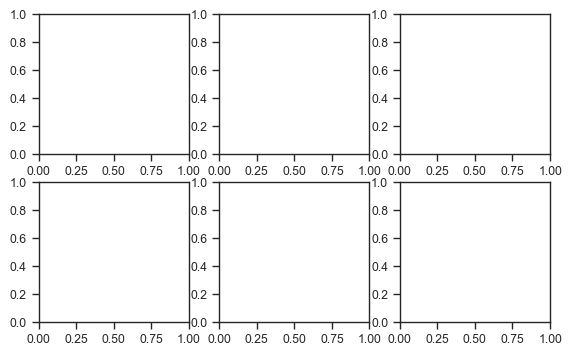

In [34]:
df = df_immediate.copy()
fig, axes = plt.subplots(2, 3, figsize=(6.6, 4))
axes = axes.flatten()


for i, feature in enumerate(features):
    featureVSday(fig, axes[i], df, feature, legend_display=True, palette=palette_drug_immediate)


# Hide x labels for the first line
for ax in axes[:3]:
    ax.set_xlabel('') 

plt.tight_layout()
plt.savefig(fig_folder / "S2 feature VS time immediate.svg", format='svg', bbox_inches='tight', transparent=False)
plt.show()

### Plot Metabolic activity VS drug

In [ ]:
# Define sigmoide equation for the fitting
def sigmoid_normalized(x, IC50, slope):
    return  100 / ( 1 + (IC50 / x) ** slope)

def plot_IC50(fig, ax, df, x, y, title="", sigmoidFit=True, marker='o', marker_col='b', line='-', line_col='b', marker_size=10, line_size=2):
    # For the log representation and fit, change the concentration '0' into a low concentration
    df.loc[:, x] = df[x].replace(0, 0.01)

    ### Plot the data as a scatter plot
    sns.scatterplot(data=df, x=x, y=y, ax=ax,
                    s=marker_size, marker=marker, color=marker_col,  alpha=0.5, legend=False) 

    ### Sigmoid fit
    if sigmoidFit == True:
        X = df[x]
        Y = df[y]

        # For the log representation and fit, change the concentration '0' into a low concentration
        X = X.replace(0, 0.01) 

        # Fit a sigmoid on the data
        ini_param = [np.median(X), -1]
        popt, pcov = curve_fit(sigmoid_normalized, X, Y, p0=ini_param)
        IC50, slope = popt

        # Create points for the fitted curve & plot
        x_fit = np.linspace(min(X), max(X), 10000)
        y_fit = sigmoid_normalized(x_fit, *popt)
        
        # Plot curve
        sns.lineplot(x=x_fit, y=y_fit, 
                            linestyle=line, color=line_col, linewidth=line_size, ax=ax)

        
    ### Graph personalization
    # Define axes limits
    
    axes[0].set_xlim(30, 90)
    axes[1].set_xlim(30, 90)

    # Change graduation
    x_ticks = [0,10,20,30,40,50,60,70,80,90]
    x_labels = ['0'] + [str(l) for l in x_ticks[1::]]
    ax.set_xticks(x_ticks, labels=x_labels)

    ax.set_title(title)

    # Set x & y axis names
    ax.set_xlabel(x)
    ax.set_ylabel(y)        
        
    ax.grid(True)
    
    return IC50, slope, popt, pcov




A673:
IC50 exp 1 = 52.53961607579995 µM
IC50 exp 2 = 49.33955521656233 µM


ValueError: cannot reindex on an axis with duplicate labels

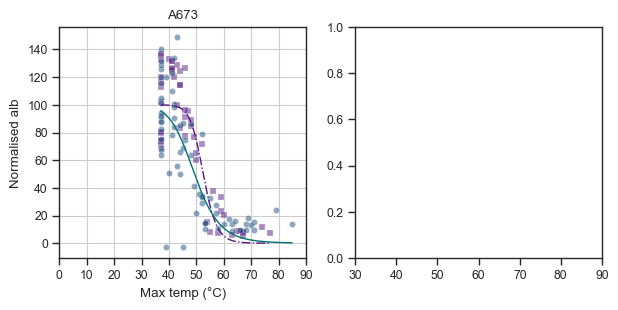

In [ ]:
x = 'Max temp (°C)'
y = 'Normalised alb'

# Initialize the figure, 2 subplots
fig, axes = plt.subplots(1, 2, figsize=(7,3))
axes = axes.flatten()

print("incubate:")
df = df_incubate.copy()
exps = df['Experiment ID'].unique()

for exp in exps:
    df_filt = df[df['Experiment ID'] == exp]
    kws_dict = kws_dict_incubate[exp]
    marker = kws_dict['marker']
    line = kws_dict['line']
    marker_col = kws_dict['marker_col']
    line_col = kws_dict['line_col']
    marker_size = kws_dict['marker_size']
    line_size = kws_dict['line_size']

    IC50, _, _, _ = plot_IC50(fig, axes[0], df_filt, x, y, title="incubate", sigmoidFit=True, marker=marker, marker_col=marker_col, line=line, line_col=line_col, marker_size=marker_size, line_size=line_size)
    print(f"IC50 exp {exp} = {IC50} µM")

print("\nimmediate:")
df = df_immediate.copy()
exps = df['Experiment ID'].unique()

for exp in exps:
    df_filt = df[df['Experiment ID'] == exp]
    kws_dict = kws_dict_immediate[exp]
    marker = kws_dict['marker']
    line = kws_dict['line']
    marker_col = kws_dict['marker_col']
    line_col = kws_dict['line_col']
    marker_size = kws_dict['marker_size']
    line_size = kws_dict['line_size']

    IC50, _, _, _ = plot_IC50(fig, axes[1], df_filt, x, y, title="immediate", sigmoidFit=True, marker=marker, marker_col=marker_col, line=line, line_col=line_col, marker_size=marker_size, line_size=line_size)
    print(f"IC50 exp {exp} = {IC50} µM")
plt.tight_layout()
# Set x-axis limits for both subplots
axes[0].set_xlim(30, 90)
axes[1].set_xlim(30, 90)
plt.show()


### Plot the features VS drug

In [ ]:
def sigmoid(x, B, T, IC50, slope):
    return B + (T - B) / (1 + (IC50 / x) ** slope)

In [ ]:
def featureVSdrug(df, x, y, ax, limits_y, kws_dict, fit=True, grad=True):
    # Replace concentration 0 for log plot
    df.loc[:, x] = df[x].replace(0, 0.01)

    # Parameters for personalization
    marker = kws_dict['marker']
    line = kws_dict['line']
    marker_col = kws_dict['marker_col']
    line_col = kws_dict['line_col']
    marker_size = kws_dict['marker_size']
    line_size = kws_dict['line_size']

    ### Plot data
    sns.scatterplot(data=df, x=x, y=y, ax=ax,
                    s=marker_size, marker=marker, color=marker_col,  alpha=0.5, legend=False)     
        
    
    ### Sigmoid fit
    if fit == True:
        # Fit the features
        B, T, IC50, slope, pcov = 0,0,0,0,0
        df_filt = df[[x, y]].dropna(subset=[y])
        
        if len(df_filt) != 0:
            X = df_filt[x]
            Y = df_filt[y]
            
            try:
                ini_param = [min(Y), max(Y), np.median(X), 1]
                popt, pcov = curve_fit(sigmoid, X, Y, p0=ini_param)
                B, T, IC50, slope = popt

                # Create points for the fitted curve
                x_fit = np.linspace(min(X), max(X), 10000)
                y_fit = sigmoid(x_fit, *popt)
            
                # Plot
                sns.lineplot(x=x_fit, y=y_fit, 
                            linestyle=line, color=line_col, linewidth=line_size, ax=ax)
                
            except RuntimeError as e:
                pass
        
       
    ### Axes formatting
    
    ax.set_xlim(0.007,110)
    ax.set_xticks([0.01,0.1,1,10,100])
    ax.set_xlabel('Max temp (°C)')
    ax.set_xticklabels(['0', '0.1', '1', '10','100'])
    ax.grid(True)
    
    ax.set_ylabel(y.split('_')[0])
    
    limits_y_key = next((key for key in limits_y if y.startswith(key)), None)
    value = limits_y.get(limits_y_key, None)
    
    if limits_y_key != None:
        ax.set_ylim(value)
    
    if grad == False :
        ax.set_yticklabels([])
        ax.set_ylabel('')
        ax.set_xticklabels([])
        ax.set_xlabel('')

##### Determine y lim
Same ylim for the same features.

In [ ]:
feats = ['Area',
   'Perimeter',
   'Circularity',
   'Aspect_Ratio',
   'Mean_Gray_Level',
   'Grey_in',
   'Grey_out',
   'Homogeneity',
   'Energy',
   'Correlation'
        ]

In [ ]:
limits_y = {}

for feat in feats:
    if feat != 'Growth' and  feat != 'Grey' and feat != 'DCorrelation_' :
        cols = [f'{feat}_day0', f'{feat}_day1', f'{feat}_day2']
    else:
        cols = [f'{feat}2-0', f'{feat}2-1', f'{feat}1-0']
        
    
    data_incubate = df_incubate[cols].values
    data_immediate = df_immediate[cols].values
    data = np.concatenate([data_incubate, data_immediate], axis=0)

    # Compute minimal and maximal values
    y_min = np.nanmin(data)
    y_max = np.nanmax(data)

    # Add a 10% marge around the extreme values
    marge = 0.05 * (y_max - y_min)
    y_min -= marge
    y_max += marge
    y_min = round(y_min,2)
    y_max = round(y_max,2)

    # Save the limits of each feature in a dictionnary
    limits_y[feat] = (y_min,  y_max)

limits_y

KeyError: "None of [Index(['Area_day0', 'Area_day1', 'Area_day2'], dtype='object')] are in the [columns]"

#### Plot & save figures

ValueError: cannot reindex on an axis with duplicate labels

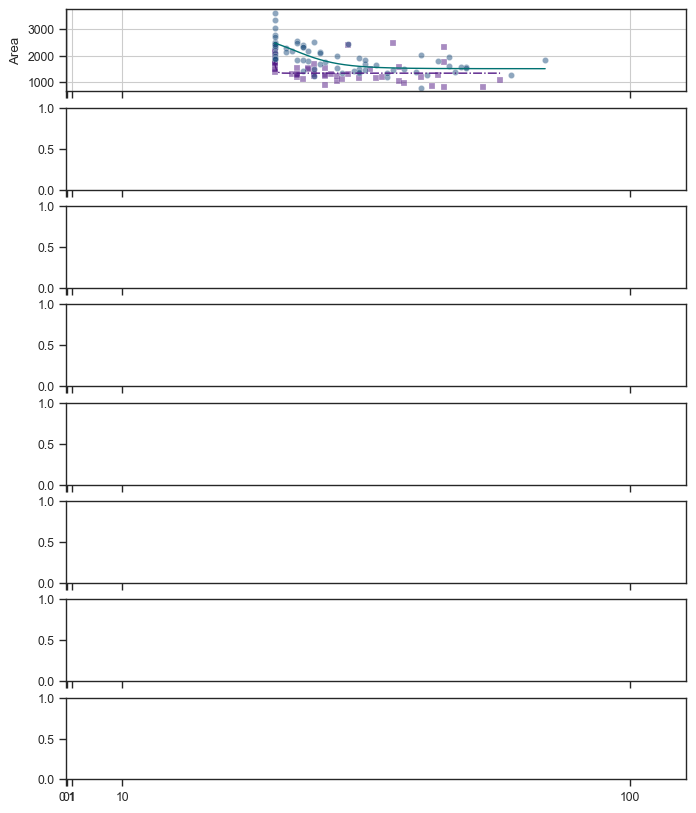

In [ ]:
y_list = [ 
    'Area',
   'Perimeter',
   'Circularity',
   'Aspect_Ratio',
   'Mean_Gray_Level',
   'Homogeneity',
   'Energy',
   'Correlation' 
    ]

# Plot incubate data
df = df_incubate.copy()
kws_dict = kws_dict_incubate
exps = df['Experiment ID'].unique()

# Initiaze figure
fig, axes = plt.subplots(8, 1, figsize = (8, 10), sharey = 'row', sharex=True)
axes = axes.flatten()

# Plot feature vs drug for each feature
for i, y in enumerate(y_list):
    for exp in exps:
        kws_dict_exp = kws_dict[exp]
        df_filt = df[df['Experiment ID'] == exp]
        featureVSdrug(df_filt, x, y, axes[i], limits_y, kws_dict_exp, fit=True, grad=True)

plt.subplots_adjust(hspace=0, wspace=0.02)
axes[0].set_xlim(30, 90)
plt.show()

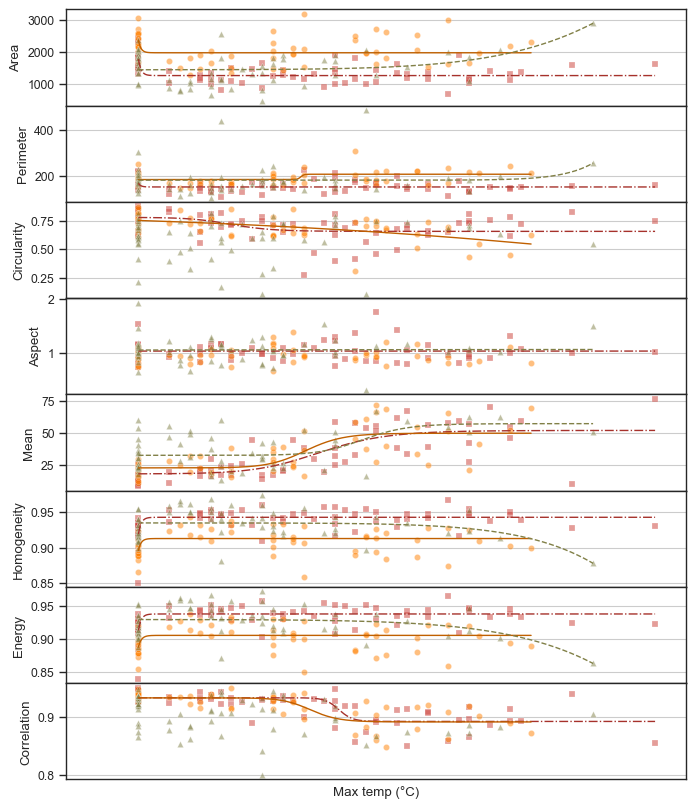

In [ ]:
# Plot immediate data
df = df_immediate.copy()
kws_dict = kws_dict_immediate
exps = df['Experiment ID'].unique()

fig, axes = plt.subplots(8, 1, figsize = (8, 10), sharey = 'row', sharex=True)
axes = axes.flatten()


for i, y in enumerate(y_list):
    for exp in exps:
        kws_dict_exp = kws_dict[exp]
        df_filt = df[df['Experiment ID'] == exp]
        featureVSdrug(df_filt, x, y, axes[i], limits_y, kws_dict_exp, fit=True, grad=True)

plt.subplots_adjust(hspace=0, wspace=0.02)
axes[1].set_xlim(30, 90)
plt.show()

### Histogram feature VS class

In [ ]:
df_incubate.columns

Index(['Area', 'Perimeter', 'Circularity', 'Aspect_Ratio', 'Mean_Gray_Level',
       'Grey_in', 'Grey_out', 'Homogeneity', 'Energy', 'Correlation',
       'Normalised alb', 'Max temp (°C)', 'Experiment ID', 'Label'],
      dtype='object')

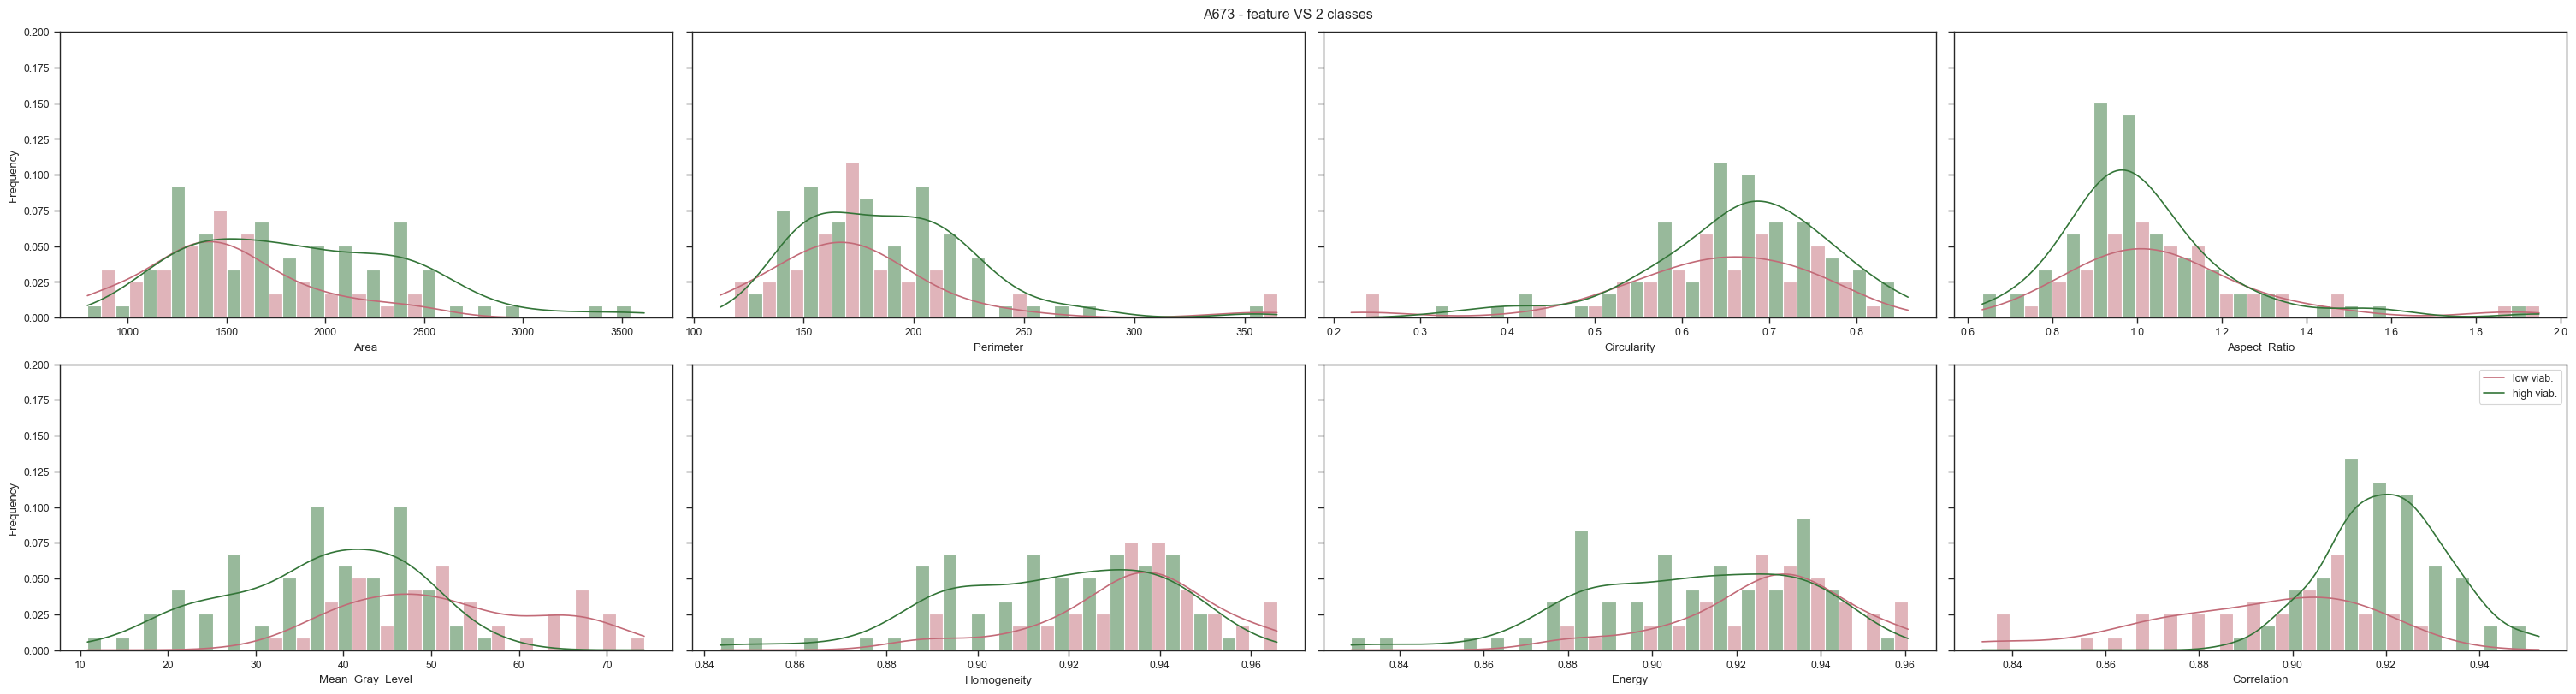

In [ ]:
df = df_incubate_copy.copy()
n_class = 2

#cols = [i for i in features if i.endswith('day2')]
cols = [
    'Area',
   'Perimeter',
   'Circularity',
   'Aspect_Ratio',
   'Mean_Gray_Level',
   'Homogeneity',
   'Energy',
   'Correlation' 
            ]


fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(30, 8), constrained_layout=True, sharey=True)
axes = axes.flatten()

fig.suptitle(f'incubate - feature VS {n_class} classes')


labels = df[f'{n_class} classes'].unique()

for idx, col in enumerate(cols):
    if idx < len(axes):
        sns.histplot(data=df, x=col, hue=f'{n_class} classes', palette=palette_class, multiple='dodge', legend=False,
                     shrink=1, ax=axes[idx], bins=20, stat='probability', kde=True
                     )
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Frequency')

axes[-1].legend(['low viab.', 'high viab.'])
axes[0].set_ylim(0, 0.2)

plt.savefig(fig_folder / "4A histogram feature vs class incubate.svg", format='svg', bbox_inches='tight', transparent=True)

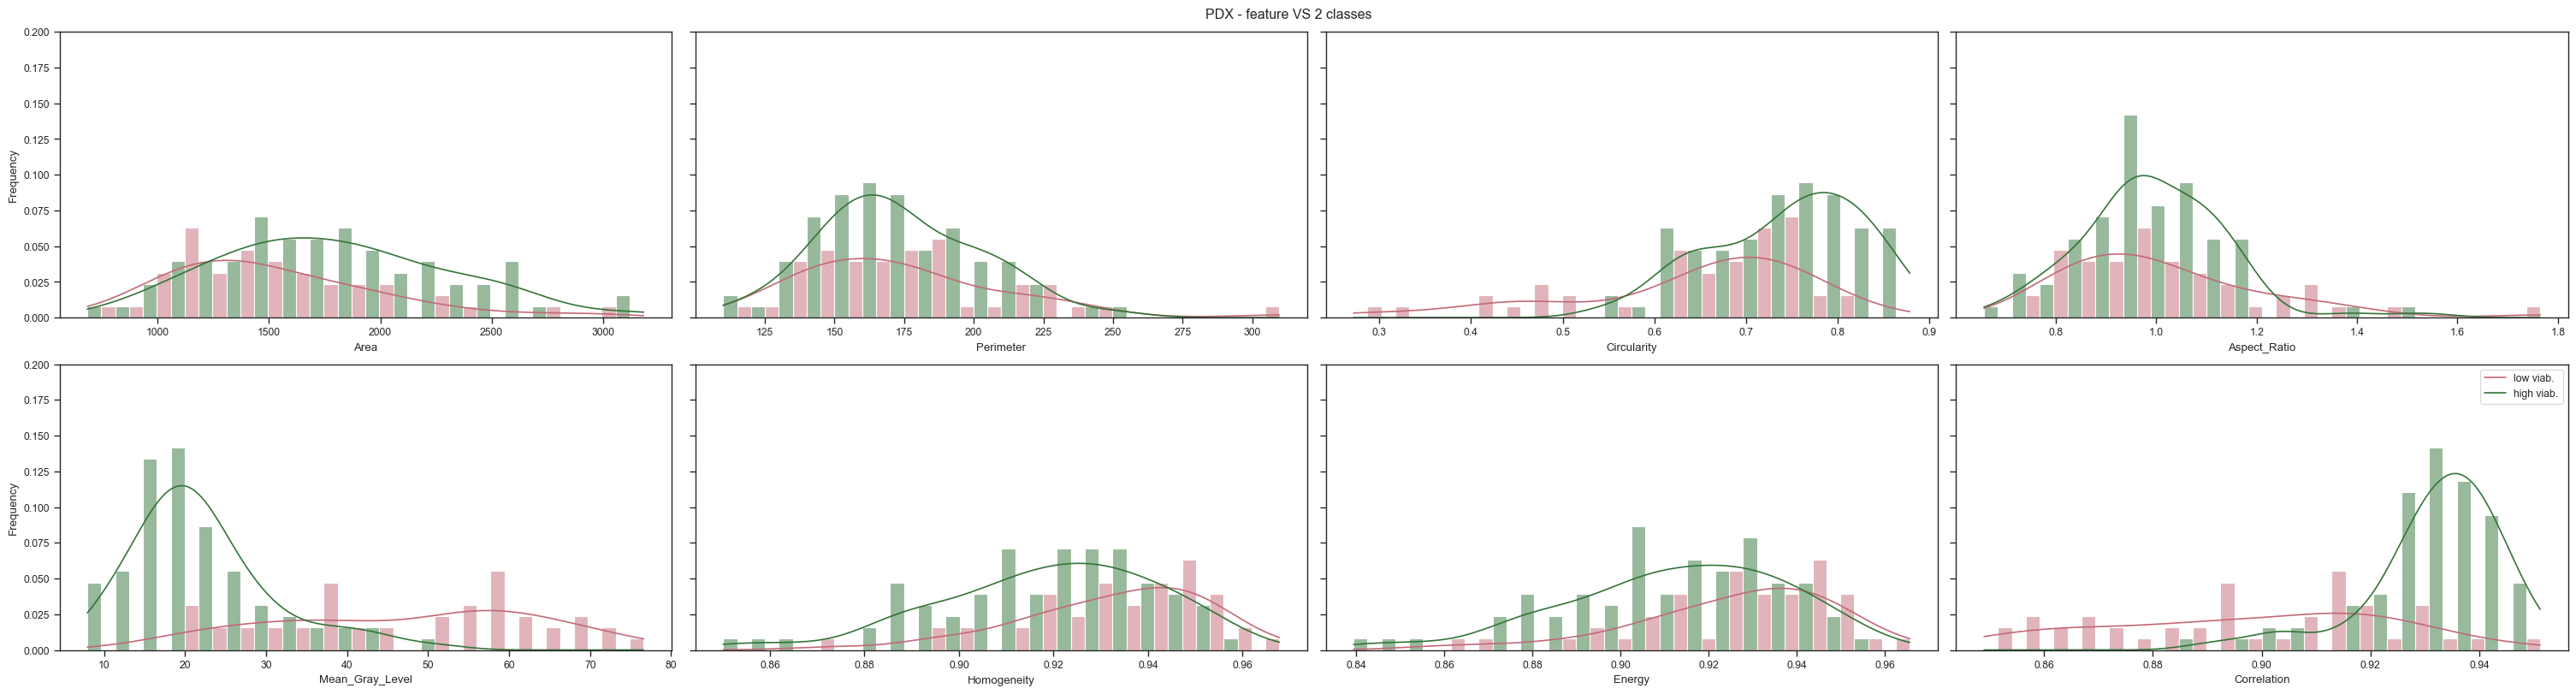

In [ ]:
X_2classes = df_immediate_copy['2 classes']
df = df_immediate_copy.copy()

#cols = [i for i in features if i.endswith('day2')]
cols = ['Area',
   'Perimeter',
   'Circularity',
   'Aspect_Ratio',
   'Mean_Gray_Level',
   'Homogeneity',
   'Energy',
   'Correlation' ]
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(30, 8), constrained_layout=True, sharey=True)
axes = axes.flatten()
fig.suptitle('immediate - feature VS 2 classes')

labels = df_incubate_copy['2 classes'].unique()

for idx, col in enumerate(cols):
    if idx < len(axes):
        sns.histplot(data=df, x=col, hue='2 classes', palette=palette_class, multiple='dodge', legend=False,
                     shrink=1, ax=axes[idx], bins=20, stat='probability', kde=True
                     )
        
        
        axes[idx].set_xlabel(col)
        axes[idx].set_ylabel('Frequency')

axes[-1].legend(['low viab.', 'high viab.'])
axes[0].set_ylim(0, 0.2)

plt.savefig(fig_folder / "4C histogram feature vs class immediate.svg", format='svg', bbox_inches='tight', transparent=True)

## Other representations

### Grey level VS viability vs drug

C:\Users\MMBM-2024-L3\AppData\Local\Temp\ipykernel_24348\1045062276.py:19: UserWarning: 
The palette list has fewer values (8) than needed (37) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data=df, x=x, y=y[int(i/2)], hue=hue, palette=palette_drug_A673, ax=axes[i], legend=False)
C:\Users\MMBM-2024-L3\AppData\Local\Temp\ipykernel_24348\1045062276.py:19: UserWarning: 
The palette list has fewer values (8) than needed (37) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data=df, x=x, y=y[int(i/2)], hue=hue, palette=palette_drug_A673, ax=axes[i], legend=False)
C:\Users\MMBM-2024-L3\AppData\Local\Temp\ipykernel_24348\1045062276.py:19: UserWarning: 
The palette list has fewer values (8) than needed (37) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data=df, x=x, y=y[int(i/2)], hue=hue, palette=palette_drug_A673, ax=axes[i], legend=False)
C:\Users\MMBM-2024-L3\AppData\Local\Temp\ipykernel_24348\1045062

ValueError: cannot reindex on an axis with duplicate labels

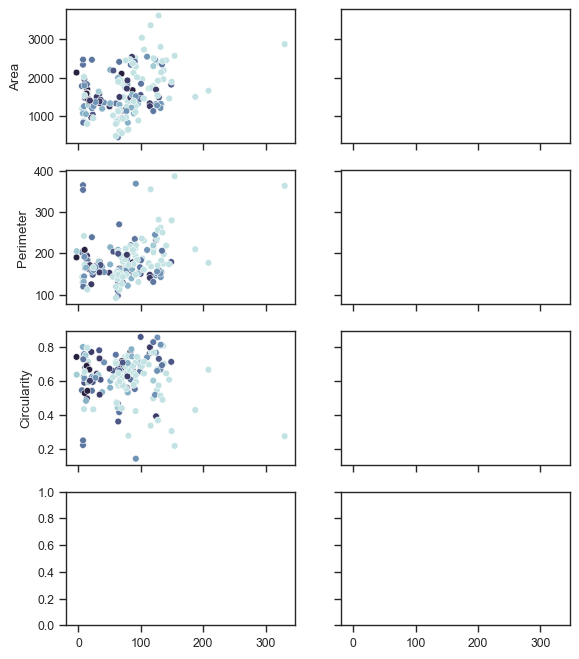

In [ ]:
x = 'Normalised alb'
y = ['Area',
   'Perimeter',
   'Circularity',
   'Aspect_Ratio',
   'Mean_Gray_Level',
   'Homogeneity',
   'Energy',
   'Correlation']
hue = 'Max temp (°C)'

fig, axes = plt.subplots(4, 2, figsize=(6.5, 8), sharex=True, sharey='row')
axes = axes.flatten()

df = df_incubate.copy()
df[hue] = pd.Categorical(df[hue], ordered=True)
for i in range(8):
    if i%2==0:
        sns.scatterplot(data=df, x=x, y=y[int(i/2)], hue=hue, palette=palette_drug_incubate, ax=axes[i], legend=False)

df = df_immediate.copy()
df[hue] = pd.Categorical(df[hue], ordered=True)
for i in range(8):
    if i%2!=0:
        sns.scatterplot(data=df, x=x, y=y[int(i/2)], hue=hue, palette=palette_drug_immediate, ax=axes[i], legend=False)

plt.tight_layout()
plt.savefig(fig_folder / "S8 features VS viability vs drug.svg", format='svg', bbox_inches='tight', transparent=True)


C:\Users\MMBM-2024-L3\AppData\Local\Temp\ipykernel_24348\1899449835.py:3: UserWarning: 
The palette list has fewer values (8) than needed (37) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data=df, x=x, hue=hue, palette=palette_drug_A673, ax=axes, legend=True)
C:\Users\MMBM-2024-L3\AppData\Local\Temp\ipykernel_24348\1899449835.py:10: UserWarning: 
The palette list has fewer values (8) than needed (37) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(data=df, x=x, hue=hue, palette=palette_drug_PDX, ax=axes, legend=True)


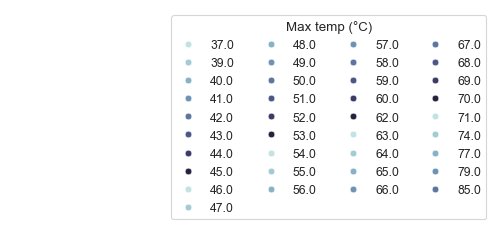

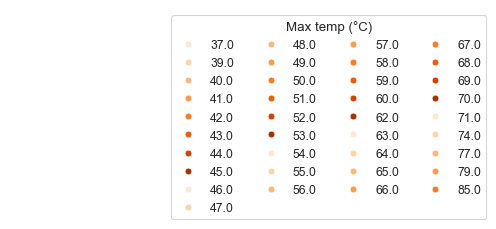

In [ ]:

# Legend
fig, axes = plt.subplots(1, 1, figsize=(2,2))
sns.scatterplot(data=df, x=x, hue=hue, palette=palette_drug_incubate, ax=axes, legend=True)
sns.move_legend(axes, loc='upper left', bbox_to_anchor=(1, 1), ncol=4)
axes.axis('off')
plt.savefig(fig_folder / "S8 legend1.svg", format='svg', bbox_inches='tight', transparent=True)

# Legend
fig, axes = plt.subplots(1, 1, figsize=(2,2))
sns.scatterplot(data=df, x=x, hue=hue, palette=palette_drug_immediate, ax=axes, legend=True)
sns.move_legend(axes, loc='upper left', bbox_to_anchor=(1, 1), ncol=4
                )
axes.axis('off')
plt.savefig(fig_folder / "S8 legend2.svg", format='svg', bbox_inches='tight', transparent=True)


ValueError: cannot reindex on an axis with duplicate labels

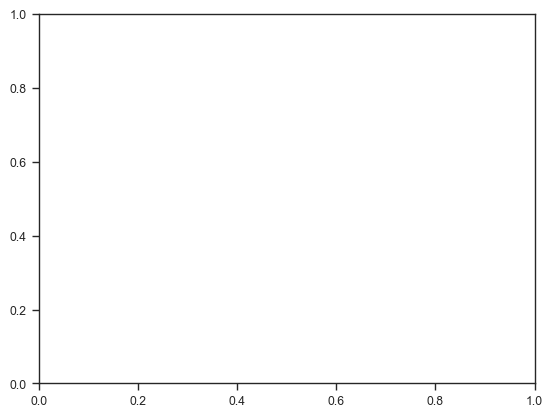

In [ ]:
x = 'Max temp (°C)'
y = 'Normalised alb'
sns.scatterplot(x=x, y=y,
        hue = 'Experiment ID',
             data=df,
             markers=True)


###

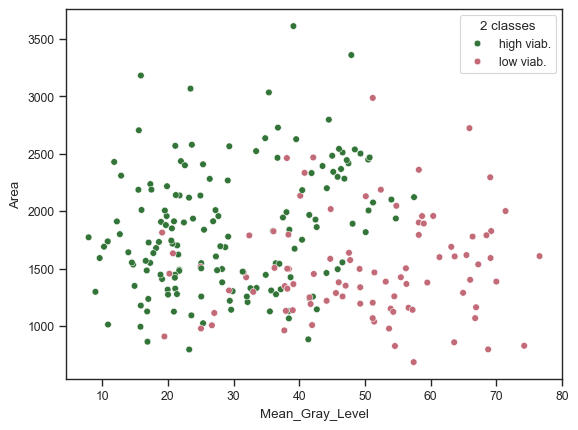

In [ ]:
x = 'Mean_Gray_Level'
y = 'Area'
hue = '2 classes'

scatter = sns.scatterplot(data=df_incubate_copy, x=x, y=y, hue=hue, palette=palette_class)
scatter = sns.scatterplot(data=df_immediate_copy,  x=x, y=y, hue=hue, palette=palette_class, legend=False)

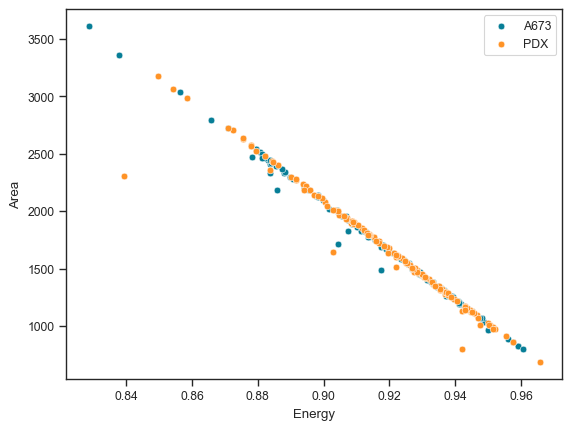

In [ ]:
x = 'Energy'
y = 'Area'

scatter = sns.scatterplot(data=df_incubate_copy, x=x, y=y, color=palette_cells['incubate'], label='incubate')
scatter = sns.scatterplot(data=df_immediate_copy, x=x, y=y, color=palette_cells['immediate'], label='immediate')

In [ ]:
x = 'Normalised alb'
y = 'Area'

sns.regplot(data=df_incubate[df_incubate_copy['Max temp (°C)']==0], x=x, y=y, color=palette_cells['incubate'], label='incubate')
sns.regplot(data=df_immediate[df_immediate_copy['Max temp (°C)']==0], x=x, y=y, color=palette_cells['immediate'], label='immediate')

C:\Users\MMBM-2024-L3\AppData\Local\Temp\ipykernel_24348\3027981033.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  sns.regplot(data=df_A673[df_A673_copy['Max temp (°C)']==0], x=x, y=y, color=palette_cells['A673'], label='A673')


IndexingError: Unalignable boolean Series provided as indexer (index of the boolean Series and of the indexed object do not match).

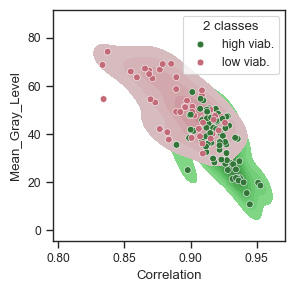

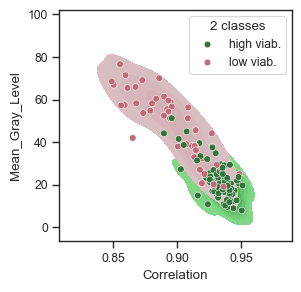

In [ ]:
x = 'Correlation'
y = 'Mean_Gray_Level'
classe = '2 classes'

df = df_incubate_copy.copy()

fig, ax = plt.subplots(figsize=(3, 3))
sns.kdeplot(data=df, x=x, y=y, hue=classe,
    fill=True, palette=palette_class)
scatter = sns.scatterplot(data=df, x=x, y=y, hue=classe, palette=palette_class)

df = df_immediate_copy.copy()

fig, ax = plt.subplots(figsize=(3, 3))
sns.kdeplot(data=df, x=x, y=y, hue=classe,
    fill=True, palette=palette_class, ax=ax
)
scatter = sns.scatterplot(data=df, x=x, y=y, hue=classe, palette=palette_class)

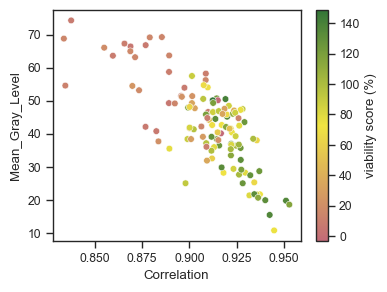

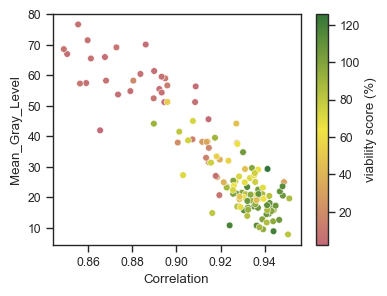

In [ ]:
### Color palette
color_start = (194/255, 106/255, 119/255)  # reddish color
color_middle = (240/255, 228/255, 66/255)  # yellowish color
color_end = (51/255, 117/255, 56/255)  # greenish color

# Create a custom colormap that transitions through the three colors
continuous_cmap = LinearSegmentedColormap.from_list("custom_palette", [color_start, color_middle, color_end])


x = 'Correlation'
y = 'Mean_Gray_Level'
viab = 'Normalised alb'

df = df_incubate_copy.copy()

fig, ax = plt.subplots(figsize=(4, 3))
scatter = sns.scatterplot(data=df, x=x, y=y, hue=viab, palette=continuous_cmap, legend=None, ax=ax)
# Add a color bar to indicate the continuous values
norm = plt.Normalize(df[viab].min(), df[viab].max())
sm = plt.cm.ScalarMappable(cmap=continuous_cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('viability score (%)')


df = df_immediate_copy.copy()

fig, ax = plt.subplots(figsize=(4, 3))
scatter = sns.scatterplot(data=df, x=x, y=y, hue=viab, palette=continuous_cmap, legend=None, ax=ax)
# Add a color bar to indicate the continuous values
norm = plt.Normalize(df[viab].min(), df[viab].max())
sm = plt.cm.ScalarMappable(cmap=continuous_cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax = ax)
cbar.set_label('viability score (%)')